Image Recognition
===

This notebook will create a convolutional neural network to classify images in either the mnist or cifar-10 datasets.

In [1]:
# Tensorflow and numpy to create the neural network
%pylab inline
import tensorflow as tf
import numpy as np

# Matplotlib to plot info to show our results
%matplotlib inline
import matplotlib.pyplot as plt

# OS to load files and save checkpoints
import os



Populating the interactive namespace from numpy and matplotlib


Loading the data
---

This code will load the dataset that you'll use to train and test the model.

The code provided will load the mnist or cifar data from files, you'll need to add the code that processes it into a format your neural network can use.

MNIST
---

Run this cell to load mnist data.

In [2]:
# Load MNIST data from tf examples




image_height = 28
image_width = 28

color_channels = 1

model_name = "mnist"



train_data = MNIST
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

category_names = list(map(str, range(10)))

# TODO: Process mnist data

print(train_data.shape)
train_data = np.reshape(train_data, (-1, image_height, image_width, color_channels))
print(train_data.shape)
eval_data = np.reshape(eval_data, (-1, image_height, image_width, color_channels))

NameError: name 'MNIST' is not defined

CIFAR-10
---

Run this cell to load cifar-10 data

In [2]:
# Load cifar data from file

image_height = 32
image_width = 32

color_channels = 3

model_name = "cifar"

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar_path = './cifar-10-data/'

train_data = np.array([])
train_labels = np.array([])

# Load all the data batches.
for i in range(1,6):
    data_batch = unpickle(cifar_path + 'data_batch_' + str(i))
    train_data = np.append(train_data, data_batch[b'data'])
    train_labels = np.append(train_labels, data_batch[b'labels'])


# Load the eval batch.
eval_batch = unpickle(cifar_path + 'test_batch')

eval_data = eval_batch[b'data']
eval_labels = eval_batch[b'labels'] 

# Load the english category names.
category_names_bytes = unpickle(cifar_path + 'batches.meta')[b'label_names']
category_names = list(map(lambda x: x.decode("utf-8"), category_names_bytes))

# TODO: Process Cifar data

def proces_data(data):
    float_data = np.array(data, dtype=float)/255.0
    
    reshaped = np.reshape(float_data, (-1, color_channels, image_height, image_width))
    transposed = np.transpose(reshaped, [0, 2, 3, 1])
    
    
    return transposed

train_data = proces_data(train_data)
eval_data = proces_data(eval_data)
    


Once the data is processed, you have a few variables for the data itself and info about its shape:

### Model Info

- **image_height, image_width** - The height and width of the processed images
- **color_channels** - the number of color channels in the image. This will be either 1 for grayscale or 3 for rgb.
- **model_name** - either "cifar" or "mnist" - if you need to handle anything differently based on the model, check this variable.
- **category_names** - strings for each category name (used to print out labels when testing results)

### Training Data

- **train_data** - the training data images
- **train_labels** - the labels for the training data - the "answer key"

### Evaluation Data

- **eval_data** - Image data for evaluation. A different set of images to test your network's effectiveness.
- **eval_labels** - the answer key for evaluation data.

Building the Neural Network Model
--

Next, you'll build a neural network with the following architecture:

- An input placeholder that takes one or more images.
- 1st Convolutional layer with 32 filters and a kernel size of 5x5 and same padding
- 1st Pooling layer with a 2x2 pool size and stride of 2
- 2nd Convolutional layer with 64 filters and a kernel size of 5x5 and same padding
- 2nd Pooling layer with a 2x2 pool size and stride of 2
- Flatten the pooling layer
- A fully connected layer with 1024 units
- A dropout layer with a rate of 0.4
- An output layer with an output size equal to the number of labels.

In [ ]:
# TODO: The neural network

class convNet:
    def __init__(self, image_height, image_width, channels, num_classes):
        
        self.input_layer = tf.placeholder(dtype=tf.float32, shape=[None, image_height, image_width, color_channels], name = "inputs")
        
        print(self.input_layer.shape)
        
        conv_layer_1 = tf.layers.conv2d(self.input_layer, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
        
        pooling_layer = tf.layers.max_pooling2d(conv_layer_1, pool_size=[2,2], strides=2)
        print(pooling_layer.shape)
        
        conv_layer_2 = tf.layers.conv2d(self.input_layer, filters=64, kernel_size=[5, 5], padding = "same", activation=tf.nn.relu)
        
        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2, pool_size=[2, 2], strides=2)
        print(pooling_layer_2.shape)
        
        flattened = tf.layers.flatten(pooling_layer_2)
        dense_layer = tf.layers.dense(flattened, 1024, activation=tf.nn.relu)
        print(dense_layer.shape)
        
        dropout = tf.layers.dropout(dense_layer, rate=0.4, training=True)
        
        outputs = tf.layers.dense(dropout, num_classes)
        print(outputs.shape)
        
        self.choice = tf.argmax(outputs, axis=1)
        
        self.probabilities = tf.nn.softmax(outputs)
        
        self.labels = tf.placeholder(dtype=tf.float32, name="labels")
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)
        
        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels, dtype=tf.int32), depth=num_classes)
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=outputs)
           
        #how fast it learns, but the faster it learns the lower the top end will be
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005)
        self.train_operation = optimizer.minimize(loss=self.loss, global_step=tf.train.get_global_step())
        

The Training Process
---

The cells below will set up and run the training process.

- Set up initial values for batch size, training length.
- Process data into batched datasets to feed into the network.
- Run through batches of training data, update weights, save checkpoints.

In [4]:
# TODO: initialize variables

steps = 20000
batch_size = 64
load_checkpoint = True
performance_graph = np.array([])

path = "./" + model_name + "-cnn/"


In [6]:
# TODO: implement the training loop

tf.reset_default_graph()

dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
dataset = dataset.shuffle(buffer_size = train_labels.shape[0])
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

cnn = convNet(image_height, image_width, color_channels, 10)

saver = tf.train.Saver(max_to_keep=2)

if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    if load_checkpoint:
        checkpoint = tf.train.get_checkpoint_state(path)
        saver.restore(sess, checkpoint.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    sess.run(iterator.initializer)
    
    for step in range(steps):
        current_batch = sess.run(next_element)
        
        batch_input = current_batch[0]
        batch_label = current_batch[1]
        sess.run((cnn.train_operation, cnn.accuracy_op), feed_dict={cnn.input_layer:batch_input, cnn.labels:batch_label})
        
        if step % 100 == 0: 
            performance_graph = np.append(performance_graph, sess.run(cnn.accuracy))
        
        
        #print the accuracy every 1000 steps
        if step % 1000 ==0 and step > 0:
            current_accuracy = sess.run(cnn.accuracy)
            
            print("accuracy at step " + str(step) + " : " + str(current_accuracy))
            print("saving")
            saver.save(sess, path + model_name, step)

(?, 32, 32, 3)
(?, 16, 16, 32)
(?, 16, 16, 64)
(?, 1024)
(?, 10)


INFO:tensorflow:Restoring parameters from ./cifar-cnn/cifar-19000


KeyboardInterrupt: 

Evaluating Performance
---

These cells will evaluate the performance of your network!

Text(0, 0.5, 'accuracy')

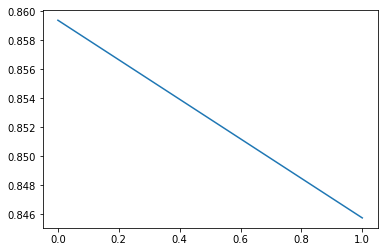

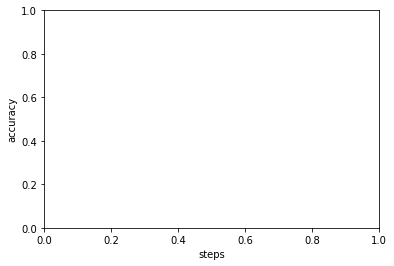

In [7]:
# TODO: Display graph of performance over time
plt.plot(performance_graph)
#sets bg to white
plt.figure().set_facecolor('white')
#sets x and y axis labels
plt.xlabel("steps")
plt.ylabel("accuracy")

In [29]:
# TODO: Run through the evaluation data set, check accuracy of model
with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
    
    sess.run(tf.local_variables_initializer())
    
    for image, label in zip(eval_data, eval_labels):
        sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer:[image], cnn.labels:label})

INFO:tensorflow:Restoring parameters from ./cifar-cnn/cifar-19000
